<a href="https://colab.research.google.com/github/paulcodrea/reddit_humor/blob/main/notebooks/1_data-collection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data Collection and Filtering

In this notebooke we:


*   Collected the data for both the funny and unfunny jokes by scraping Reddit.
*   Handled unreliable data by filtering the jokes using an engagement trehsold. The Threshold is an arbitrary value.
*   Handled data imbalance by ensuring both classes have a 50/50 split.
*   Pre-processed the data. Handled sampling bias by ensuring all jokes have similar formats (no emojis, no non-words, where applicable we also concatenated the title with the body of the post).
*   Added all data + labels in a csv file to be used by the training and testing steps.




In [ ]:
pip install emoji

In [ ]:
import requests
import pandas as pd
from matplotlib import pyplot as plt
from difflib import SequenceMatcher
import emoji
import re
from nltk.tokenize import word_tokenize
import nltk
nltk.download('punkt')
from nltk.corpus import stopwords
nltk.download('stopwords')
stopWords = set(stopwords.words('english'))
from nltk.tokenize import RegexpTokenizer

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### Defining methods for scraping the Reddit threads


The methods below help us scrape a Reddit thread URL, transform the JSON data, and concatenate the titles of the posts with their body_text (concatenating the joke with the punchline).

In [ ]:
def scrape_url(url, pages=0):
  """ 
  Scrapes a url and returns a list of JSON.
  """
  resp = requests.get(url=url, headers = {'User-agent': 'Humour detection bot'}, params = {'limit': '100'})
  data = resp.json()
  ret = []
  ret.append(data)
  
  # if more than 100 data points are needed:
  if pages != 0:
    for i in range(pages):
      after_param = data['data']['after'] 
      data = requests.get(url=url, headers = {'User-agent': 'Humour detection bot'}, params = {'after': after_param, 'limit': '100'})
      data_2 = data.json()
      ret.append(data_2)
      data = data_2

  return ret

def make_list_from_json(json_list):
  """
  Makes a list from a json list.
  """
  ret = []
  for collection in json_list:
    collection_list = collection['data']['children']
    for joke_index in range(len(collection_list)):
      ret.append(collection_list[joke_index]['data'])
  return ret

def transform_data(data):
  """ 
  Transforms data to a dataframe. Ans only keeps the columns that are needed.
  """
  df = pd.DataFrame(data)
  ret = pd.DataFrame()

  ret['title'] = df['title']
  ret['selftext'] = df['selftext']
  ret['ups'] = df['ups']
  ret['downs'] = df['downs']
  ret['upvote_ratio'] = df['upvote_ratio']
  ret['total_awards_received'] = df['total_awards_received']

  return ret


The method below enables us to analyse the collected data by plotting the stats of the reddit jokes:

In [ ]:
"""
Print out a pie chart showing how many jokes are funny/have a high engagement 
and unfunny/low engagement.
The treshold used will be by default the mean of the engagement scores (upvote ratio).
"""
def visualise_data(data_df, type_data="funny"or"engagement", treshold=None):
  label_1 = "Funny"
  label_2 = "Not funny"
  if type_data == "engagement":
    label_1 = "High engagement"
    label_2 = "Low engagement"

  # calculate number of posts with upvotes different grater than downvotes
  funny = data_df[data_df['ups'] > data_df['downs']]
  # not_funny = clean_df[clean_df['ups'] <= clean_df['downs']]
  no_engagement = len(data_df[(data_df['ups'] == 0) & (data_df['downs'] == 0)])


  #calculate how many have only upvotes and zero downvotes
  upvotes_count = downvotes_count = 0
  for index in range(len(data_df)):
      if data_df['ups'][index] > 0:
          upvotes_count += 1

  print("Number of jokes with upvotes different from zero: ", upvotes_count)
  print("Number of jokes with no engagement: ", no_engagement)
  
  treshhold_ups = data_df['ups'].mean()
  print("Average number of upvotes: ", treshhold_ups)
  threshold_ratio = clean_df['upvote_ratio'].mean()
  if(treshold):
    threshold_ratio = treshold
  print("Average upvote ratio: ", threshold_ratio)


  funny_percentage = len(funny) / len(data_df) * 100
  no_engagement_percentage = no_engagement / len(data_df) * 100


  plt.figure(figsize=(4,4))
  plt.pie([funny_percentage, no_engagement_percentage], labels=[label_1, label_2], autopct='%1.1f%%', colors=['green', 'red'])
  plt.show()

# Scraping r/dadjokes


In [ ]:
url = "https://www.reddit.com/r/dadjokes.json"
data = scrape_url(url, 200)
data = make_list_from_json(data)
# save only relevant colums
clean_df = transform_data(data)

Compute the engagement tresholds

In [ ]:
treshhold_ups = clean_df['ups'].mean()
threshold_ratio = clean_df['upvote_ratio'].mean()

Visualise the data

Number of jokes with upvotes different from zero:  17195
Number of jokes with no engagement:  2047
Average number of upvotes:  227.75236461906246
Average upvote ratio:  0.8116692651491297


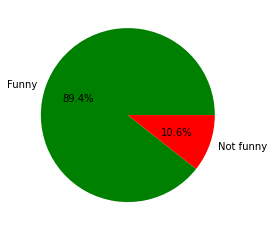

In [ ]:
visualise_data(clean_df, "funny")

## Filter Jokes

Although all jokes scraped from r/DadJokes are considered funny, in order to handle unreability we will filter out the jokes that don't have engagement/ their engagement is low compared to the average value.

In [ ]:
unfunny_but_awarded = 0
funny = 0
count = 0
jokes_dataset = pd.DataFrame()

for index in range(len(clean_df)):
  if clean_df['ups'][index] > treshhold_ups and clean_df['upvote_ratio'][index] > threshold_ratio:
    jokes_dataset = jokes_dataset.append(clean_df.iloc[count])
    count = count + 1
    funny = funny + 1



print('Total jokes: ', len(clean_df))
print('Jokes that are not that funny but have awards: ', unfunny_but_awarded)
print('Jokes that are funny according to our treshold: ', funny)
print('funny ratio ', funny/len(clean_df)) # Q - what is this

Total jokes:  19242
Jokes that are not that funny but have awards:  0
Jokes that are funny according to our treshold:  1413
funny ratio  0.0734331150608045


## Building the final CSV

Analysing the data and building the final Funny CSV



In [ ]:
# add one more column to jokes_dataset with length of selftext
jokes_dataset['title_length'] = jokes_dataset['title'].apply(len)
jokes_dataset['selftext_length'] = jokes_dataset['selftext'].apply(len)
print("The highest length of title is ", jokes_dataset['title_length'].max())
print("The highest length of the joke is: ", jokes_dataset['selftext_length'].max())

The highest length of title is  210
The highest length of the joke is:  1549


Saving the jokes in a CSV file to be used by our models.

In [ ]:
jokes_dataset.to_csv(f'reddit_funny_dadjokes({len(jokes_dataset)}).csv')

# Scraping r/badjokes


In [ ]:
url = "https://www.reddit.com/r/badjokes.json"
data_neg = scrape_url(url, 100)
data_neg = make_list_from_json(data_neg)
# Save only important columns in dataframe
badjokes_dataset = transform_data(data_neg)

In [ ]:
print("This is how many un-funny jokes we have collected ", len(badjokes_dataset))

This is how many un-funny jokes we have collected  9360


Number of jokes with upvotes different from zero:  8919
Number of jokes with no engagement:  441
Average number of upvotes:  28.986538461538462
Average upvote ratio:  0.8116692651491297


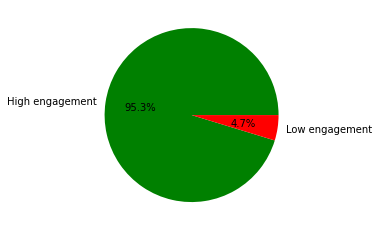

In [ ]:
visualise_data(badjokes_dataset, "engagement")

As opposed to the r/DadJokes dataset, we don't care if the unfunny jokes don't get any engagement, so we don't filter any data based on this.

In [ ]:
# save jokes_dataset in a csv file
badjokes_dataset.to_csv(f'reddit_badjokes({len(badjokes_dataset)}).csv')

# Scraping r/sciencefacts

In [ ]:
url = "https://www.reddit.com/r/sciencefacts.json"
facts_df = scrape_url(url, 100)
facts_df = make_list_from_json(facts_df)
# save only relevant colums
facts_df = transform_data(facts_df)

In [ ]:
facts_df.to_csv(f'reddit_sciencefacts({len(facts_df)}).csv')

# Set HyperParameters

Setting hyperparameters to generate different datasets, depending on what experiments we want to run.

In [ ]:
delete_stop_words = True
remove_punctuation = True
case_folding = True

# Generate final dataset

Adding a label column to each CSV

In [ ]:
# Create one more column for jokes_dataset filles with 1
jokes_dataset['funny'] = 1
badjokes_dataset['funny'] = 0
facts_df['funny'] = 0

concat_title_and_body - a method to concatenate the titles and the body text. This will ensure each joke has the text + punchline format.

preprocess - tokenise, clead data: remove stop words, remove punctuation, remove emojis and URLs.

get-token-number - add a new column with the number of tokens from each joke

In [ ]:
def concat_title_and_body(data_set):
  """
  Preprocesses data to concatenate title and punchline into one string.
  """
  data_set['joke'] = ''
  for joke_index in range(len(data_set)):
    title = data_set['title'][joke_index]
    separator = ' '
    if title[len(title) - 1].isalpha():
        separator = '. '
    data_set['joke'][joke_index] = data_set['title'][joke_index] + separator + data_set['selftext'][joke_index] 
    joke = data_set['joke'][joke_index]
    if joke[len(joke) - 1].isalpha():
      data_set['joke'][joke_index] = joke + '.'

  return data_set

def removeStopWords(words):
  """
  Remove the stop-words from a list.
  """
  filtered_words = []
  for w in words:
      if w not in stopWords:
          filtered_words.append(w)
  return filtered_words

def preprocess(re_data, delStopWords=True, removePunctuation=True, lowerTokens=True):
  """
  Remove non-words (hyperlinks and emojis).
  Remove stop words, lower text and punctuation.
  Add a new column with the tokenised text.
  """
  emoji_pattern = re.compile("["
  u"\U0001F600-\U0001F64F"  # emoticons
  u"\U0001F300-\U0001F5FF"  # symbols & pictographs
  u"\U0001F680-\U0001F6FF"  # transport & map symbols
  u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
  "]+", flags=re.UNICODE)


  # Remove URLs
  re_data['joke'] = re_data['joke'].apply(lambda x: ' '.join(word for word in x.split() if not word.startswith('http')))
  # Tokenise the text
  if(removePunctuation == True):
    tokenizer = RegexpTokenizer(r'\w+')
    re_data['tokens'] = re_data['joke'].apply(tokenizer.tokenize)
  else:
    # remove emojis
    re_data['tokens'] = re_data['tokens'].apply(lambda x: ' '.join(word for word in x if not re.search(emoji_pattern, word))) 
    re_data['tokens'] = re_data['tokens'].apply(word_tokenize) # tokenize the text again
  if(delStopWords == True):
    for index, row in re_data.iterrows():
      re_data['tokens'][index] = removeStopWords(re_data['tokens'][index])
  if(lowerTokens):
    for index, row in re_data.iterrows():
      for index in range(len(row['tokens'])):
        row['tokens'][index] = row['tokens'][index].lower()
  
  return re_data

def get_token_number(re_data):
  """
  Returns the maximum number of tokens in the dataset.
  """
  re_data['token_count'] = 0
  # create a new column in the dataframe with max tokens per row. and count only if the token isalpha()
  for index, row in re_data.iterrows():
    count = 0
    for token in row['tokens']:
      if token.isalpha():
        count += 1
      re_data['token_count'][index] = count

  return re_data

def merge_tokens_for_csv(re_data):
  # add ' ' between the tokens
  re_data['clean_text'] = ''
  for index, row in re_data.iterrows():
    joke_string = ''
    for token in row['tokens']:
      joke_string = joke_string + token
      joke_string = joke_string + ' '
    re_data['clean_text'][index] = joke_string
  return re_data

  

Pre-process both CSV and concatenate them into a final data set.

In [ ]:
def run_all_preprocessing(data_set, delStopWords=True, removePunctuation=True, lowerTokens=True):
  data_set = concat_title_and_body(data_set)
  data_set = preprocess(data_set, delStopWords, removePunctuation, lowerTokens)
  data_set = get_token_number(data_set)
  data_set = merge_tokens_for_csv(data_set)
  
  return data_set

def generate_dataset_name(data_set_size, delStopWords, removePunctuation, lowerTokens):
  name = f'({data_set_size})'
  if delStopWords == False: 
    name = name + '(stopwords)'
  if removePunctuation == False:
    name = name + '(punctuation)'
  if lowerTokens == False:
    name = name + '(uppercase)'
  return name


In [ ]:
jokes_dataset = run_all_preprocessing(jokes_dataset,delete_stop_words, remove_punctuation, case_folding)
badjokes_dataset = run_all_preprocessing(badjokes_dataset,delete_stop_words, remove_punctuation, case_folding)

# ensure 50/50 split
if len(badjokes_dataset) < len(jokes_dataset):
  jokes_dataset = jokes_dataset.head(len(badjokes_dataset))
else:
  badjokes_dataset = badjokes_dataset.head(len(jokes_dataset))

In [ ]:
# create jokes_df with jokes_dataset specific columns
jokes_df = pd.DataFrame()
jokes_df['joke'] = jokes_dataset['joke']
jokes_df['tokens'] = jokes_dataset['tokens']
jokes_df['token_count'] = jokes_dataset['token_count']
jokes_df['funny'] = jokes_dataset['funny']
jokes_df['clean_text'] = jokes_dataset['clean_text']

#concat to jokes_df with badjokes_dataset specific columns
jokes_df = jokes_df.append(badjokes_dataset, ignore_index=True)
# remove title, selftext, ups, downs, upvote_ratio, total_awards_received
jokes_df = jokes_df.drop(['title', 'selftext', 'ups', 'downs', 'upvote_ratio', 'total_awards_received'], axis=1)

In [ ]:
jokes_df = jokes_df.sample(frac=1, ignore_index=True)

In [ ]:
# save final_df in a csv file
jokes_df.to_csv(f'final_jokes{generate_dataset_name(len(jokes_df),delete_stop_words, remove_punctuation, case_folding)}.csv')

Repeat process for third dataset:

In [ ]:
facts_df = run_all_preprocessing(facts_df, delete_stop_words, remove_punctuation, case_folding)
facts_df = facts_df.head(len(jokes_dataset))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:54: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_la

In [ ]:
# create final_df with jokes_dataset specific columns
jokes_facts_df = pd.DataFrame()
jokes_facts_df['joke'] = jokes_dataset['joke']
jokes_facts_df['tokens'] = jokes_dataset['tokens']
jokes_facts_df['token_count'] = jokes_dataset['token_count']
jokes_facts_df['funny'] = jokes_dataset['funny']
jokes_facts_df['clean_text'] = jokes_dataset['clean_text']
#concat to final_df with badjokes_dataset specific columns
jokes_facts_df = jokes_facts_df.append(facts_df, ignore_index=True)
# remove title, selftext, ups, downs, upvote_ratio, total_awards_received
jokes_facts_df = jokes_facts_df.drop(['title', 'selftext', 'ups', 'downs', 'upvote_ratio', 'total_awards_received'], axis=1)

In [ ]:
jokes_facts_df = jokes_facts_df.sample(frac=1, ignore_index=True)

In [ ]:
jokes_facts_df.to_csv(f'final_jokes_and_facts{generate_dataset_name(len(jokes_facts_df),delete_stop_words, remove_punctuation, case_folding)}.csv')

# Experiment with similarity scores

In [ ]:
normalised_jokes = []
for joke_index in range(len(jokes_dataset)):
  if jokes_dataset['title_length'][joke_index] + jokes_dataset['selftext_length'][joke_index] < 200:
    normalised_jokes.append(joke_index)
print(len(normalised_jokes))

1349


In [ ]:

max = 0
index_similar = 0
jokes_dataset['similarity'] = ''
for joke_index in range(len(jokes_dataset)):
  title = jokes_dataset['title'][joke_index]
  text = jokes_dataset['selftext'][joke_index]

  title_words = title.split()
  text_words = text.split()
  final_score = 0
  for title_word in title_words:
    for text_word in text_words:
      s = SequenceMatcher(None,title_word,text_word)
      match_freq = s.ratio()
      final_score += 1
  jokes_dataset['similarity'][joke_index] = final_score
  if final_score > max and joke_index in normalised_jokes:
    index_similar = joke_index
    max = final_score
print(jokes_dataset['joke'][index_similar])


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


I took my worst enemy out to dinner at a steakhouse to try to reconcile our differences. When we ordered the same thing, I thought we were seeing eye to eye, but he still had beef with me.
